# Package Installation

In [1]:
#!pip install opencv-python seaborn

In [2]:
#!pip install tensorflow-addons

In [3]:
#!pip install tensorflow numpy matplotlib seaborn opencv-python scikit-image scikit-learn


# Setup

In [4]:
# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import time

# Sklearn Libraries
from sklearn.model_selection import train_test_split
from skimage import color, exposure, io, feature
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [5]:
# Check Versions of the crucial libraries
# print("TensorFlow Version: ", tf.__version__)
# print("NumPy Version: ", np.__version__)
# print("OpenCV Version: ", cv2.__version__)

In [6]:
def PrepareData(data_dir = "ProcessedDates", img_size=(128,128)):
    date_types = {
        'K': 'Sukkari', 'J': 'Ajwa', 'W': 'Safawi', 'Q': 'Saqi', 'B': 'Barhi', 'A': 'Amber', 'L': 'Medjool', 'I': 'Rabiah', 'S': 'Shalabi'
    }
    images = []
    labels = []
    label_to_index = {letter: i for i, letter in enumerate(date_types.keys())}
    
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = io.imread(img_path)

                if img is not None:
                    # img = cv2.resize(img, img_size)
                    img = img / 255.0
                    images.append(img)
                    
                    # Extract label from the first letter of the filename
                    label_letter = file[0].upper()
                    
                    if label_letter in label_to_index:
                        labels.append(label_to_index[label_letter])
                    else:
                        print(f"Warning: Unrecognized label for file {file}")
    
    return np.array(images), np.array(labels), date_types


In [7]:
def Segmentation(img):
    # Convert image to uint8
    img_uint8 = (img * 255).astype(np.uint8)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)

    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,  
        11,  # Block size (size of the neighborhood)
        2    # Constant subtracted from the mean
    )

    return binary

In [8]:
def FeatureExtraction(img):
    # Ensure the image is in uint8 format
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    
    # Convert to grayscale if it's not already
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    

    # Complementary to other techniques, HOG is a global feature descriptor that describes the shape of an object.
    # Effective object detection: HOG is particularly effective for object detection.
    features = feature.hog(gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))
    return features

""" Other options were: 
SIFT (Scale-Invariant Feature Transform): Detecting and describing local features in images
SURF (Speeded Up Robust Features): Similar to SIFT but faster
Local Binary Pattern (LBP): Facial recognition"""

' Other options were: \nSIFT (Scale-Invariant Feature Transform): Detecting and describing local features in images\nSURF (Speeded Up Robust Features): Similar to SIFT but faster\nLocal Binary Pattern (LBP): Facial recognition'

In [9]:
def Augmentation_Processing(img, label, num_augmentations=5):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    features_list = []
    labels_list = []
    
    # Process original image
    segmented = Segmentation(img)
    features = FeatureExtraction(segmented)
    features_list.append(features)
    labels_list.append(label)
    
    # Generate and process augmented images
    img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator
    augmented_images = datagen.flow(img, batch_size=1)
    
    for _ in range(num_augmentations):
        aug_img = next(augmented_images)[0]
        aug_segmented = Segmentation(aug_img)
        aug_features = FeatureExtraction(aug_segmented)
        features_list.append(aug_features)
        labels_list.append(label)
    
    return features_list, labels_list

In [10]:
def FinalStage(X , y):
    X_processed = []
    y_processed = []

    for img, label in zip(X, y):
        features, labels = Augmentation_Processing(img, label)
        X_processed.extend(features)
        y_processed.extend(labels)

    X_processed = np.array(X_processed)
    y_processed = np.array(y_processed)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    print(f"Processed data shape: {X_processed.shape}, {y_processed.shape}")
    print(f"Number of classes: {len(np.unique(y_processed))}")

    return X_train, X_test, X_val, y_train, y_test, y_val

# CNN

## CNN Model 1

In [11]:
# Load and preprocess data
X, y, date_types = PrepareData(img_size=(128, 128))
X_train, X_test, X_val, y_train, y_test, y_val = FinalStage(X, y)

num_classes = 9
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

Processed data shape: (16932, 512), (16932,)
Number of classes: 9


In [12]:
print(f"Image shape: {X[0].shape}, dtype: {X[0].dtype}")

Image shape: (128, 128, 3), dtype: float64


In [13]:
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1805, 128, 128, 3)
Validation set shape: (452, 128, 128, 3)
Test set shape: (565, 128, 128, 3)


In [14]:
def CNN1(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(9, activation='softmax')
    ])
    return model

In [15]:
input_shape = X_train.shape[1:]
print(f"Input shape: {input_shape}")

Input shape: (128, 128, 3)


In [16]:
model = CNN1(input_shape)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\themi\anaconda3\envs\GenAI\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,268,233 (12.47 MB)

 Trainable params: 3,268,233 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32
)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.3116 - loss: 1.8925 - val_accuracy: 0.5973 - val_loss: 1.1093
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7018 - loss: 0.8505 - val_accuracy: 0.7876 - val_loss: 0.5785
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8403 - loss: 0.4693 - val_accuracy: 0.7876 - val_loss: 0.5927
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8792 - loss: 0.3138 - val_accuracy: 0.8650 - val_loss: 0.3779
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9345 - loss: 0.1996 - val_accuracy: 0.8584 - val_loss: 0.3599
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9541 - loss: 0.1608 - val_accuracy: 0.8717 - val_loss: 0.3678
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9516 - loss: 0.1433 - val_accuracy: 0.8296 - val_loss: 0.6122
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9353 - loss: 0.1876 - val_accuracy: 0.8673 - v

In [19]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Training accuracy: {history.history["accuracy"][-1]}')
print(f'Test accuracy: {test_acc}')

Training accuracy: 0.9850415587425232
Test accuracy: 0.8548672795295715


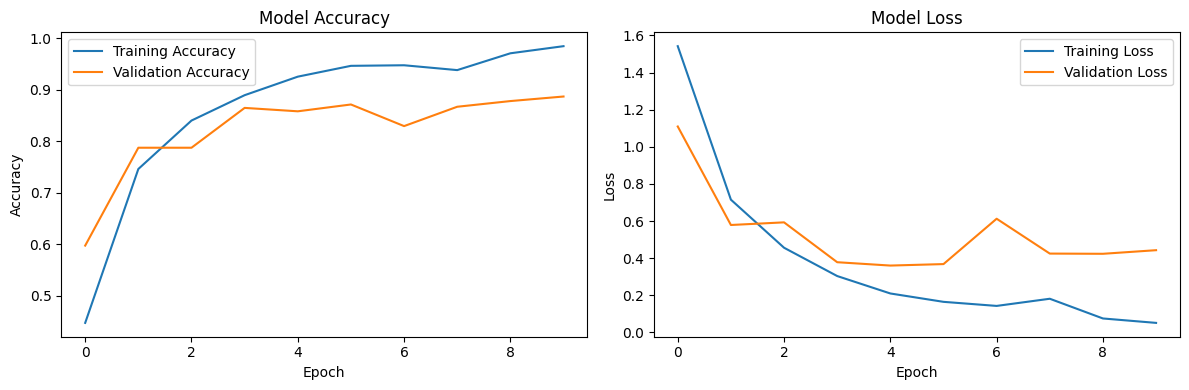

In [20]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Number of examples:  565


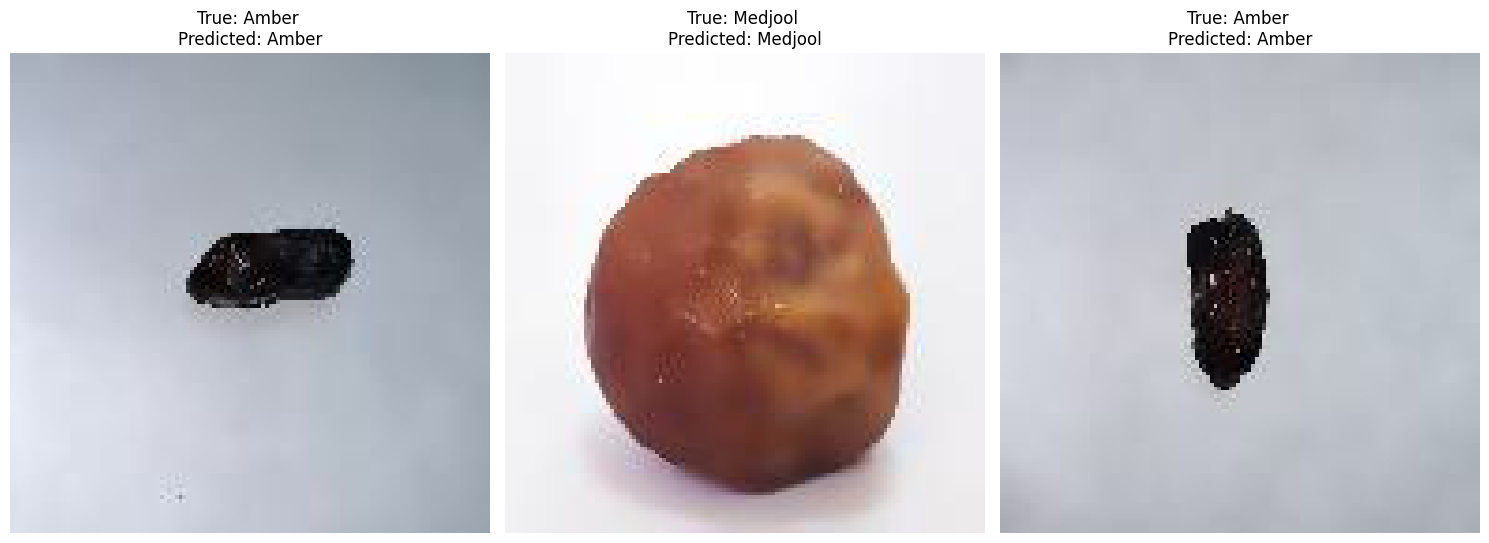

In [22]:
# Display some predictions
date_type_list = list(date_types.values())
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
print("Number of examples: ", len(X_test))
for i, ax in enumerate(axes.flat):
    i=np.random.randint(0,len(X_test))
    ax.imshow(X_test[i].reshape(input_shape))
    ax.set_title(f"True: {date_type_list[np.argmax(y_test[i])]} \nPredicted: {date_type_list[predicted_classes[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Pre-Trained Models

## Inception-v3 Model

* Efficiently balances depth and computational cost, reducing overfitting risks on specific datasets.
* Performs exceptionally well in scenarios with subtle class differences, like date type classification.
* Combines information from multiple scales, enhancing its ability to distinguish between visually similar objects.
* Pre-trained Inception-v3 models are highly effective for datasets requiring detailed visual analysis.

In [23]:
# Done to reset the model to not get confused with the previous model
from tensorflow.keras.models import Model 

def InceptionV3_Model(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [24]:
X, y, date_types = PrepareData(img_size=(128, 128))
X_train, X_test, X_val, y_train, y_test, y_val = FinalStage(X, y)

num_classes = 9
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

Processed data shape: (16932, 512), (16932,)
Number of classes: 9


In [25]:
input_shape = (128, 128, 3)
inception_model = InceptionV3_Model(input_shape, num_classes)

inception_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = inception_model.fit(X_train, y_train,
                           epochs=10,
                           batch_size=32,
                           validation_data=(X_val, y_val),
                           verbose=1)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.5003 - loss: 4.8813 - val_accuracy: 0.8186 - val_loss: 0.5814
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.8406 - loss: 0.4283 - val_accuracy: 0.7810 - val_loss: 0.6488
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.8942 - loss: 0.2940 - val_accuracy: 0.8363 - val_loss: 0.4429
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9546 - loss: 0.1282 - val_accuracy: 0.8805 - val_loss: 0.4141
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9546 - loss: 0.1151 - val_accuracy: 0.8783 - val_loss: 0.3838
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.9814 - loss: 0.0603 - val_accuracy: 0.8562 - val_loss: 0.4438
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.9983 - loss: 0.0271 - val_accuracy: 0.8783 - val_loss: 0.3822
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9978 - loss: 0.0165 - val_accuracy: 0

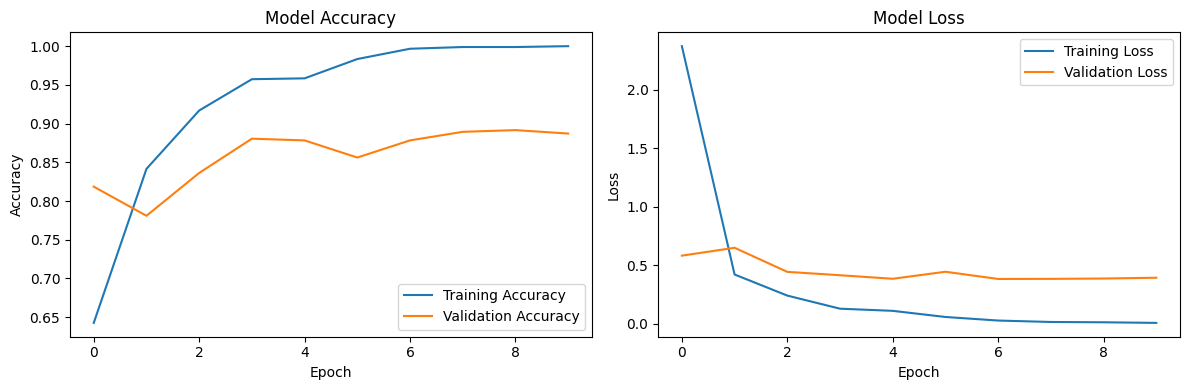

In [26]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Evaluate the model
test_loss, test_acc = inception_model.evaluate(X_test, y_test, verbose=0)
print(f'Training accuracy: {history.history["accuracy"][-1]}')
print(f'Test accuracy: {test_acc}')

Training accuracy: 1.0
Test accuracy: 0.886725664138794


In [28]:
# Make predictions
predictions = inception_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step


Number of examples:  565


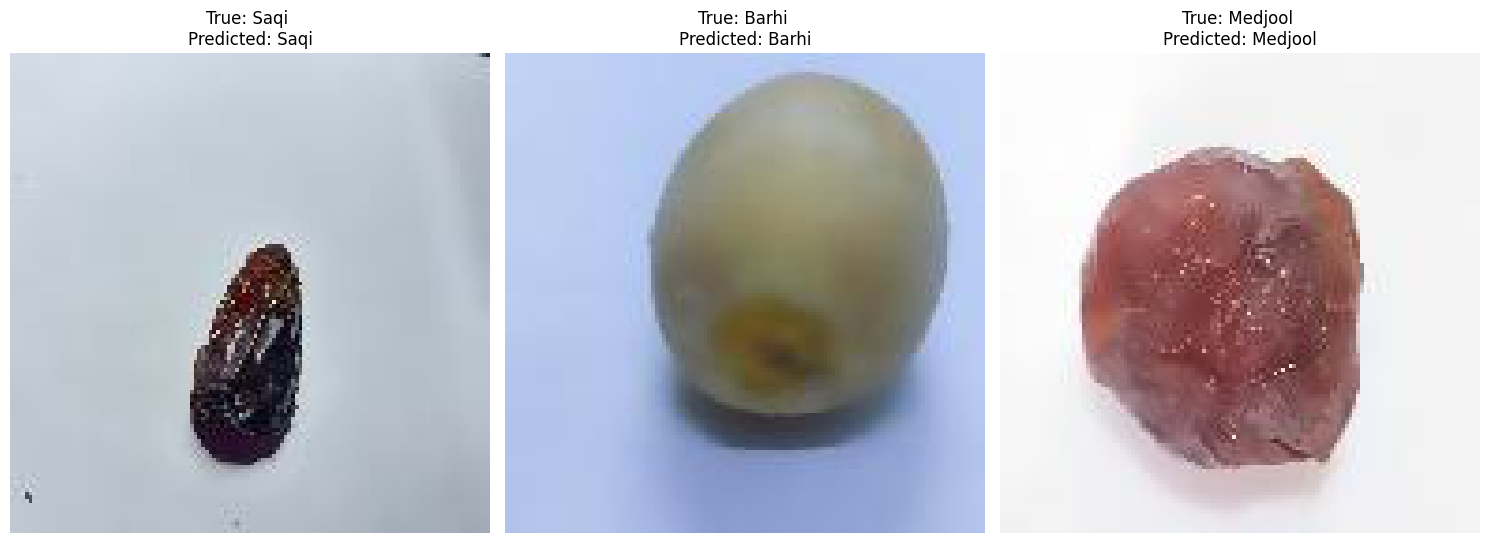

In [29]:
# Display some predictions
date_type_list = list(date_types.values())
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
print("Number of examples: ", len(X_test))
for i, ax in enumerate(axes.flat):
    i=np.random.randint(0,len(X_test))
    ax.imshow(X_test[i])
    ax.set_title(f"True: {date_type_list[np.argmax(y_test[i])]} \nPredicted: {date_type_list[predicted_classes[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

**Inception-v3 excelled because it is designed to handle fine-grained classification tasks by extracting details at multiple scales, which matched your dataset’s needs.**

## Resnet50 Model

* Deep architecture with skip connections to handle vanishing gradients effectively.
* Performs well on a variety of image classification tasks.
* Captures both low-level and high-level patterns.
* Widely available for fine-tuning.
* Known for handling tasks with high intra-class variability, making it a good initial choice for visually similar date types.

In [30]:
# Done to reset the model to not get confused with the previous model
from tensorflow.keras.models import Model 

def ResNet50_Model(input_shape, num_classes):
    # Load the ResNet50 model with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Combine the base model and custom layers
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [31]:
X, y, date_types = PrepareData(img_size=(128, 128))
X_train, X_test, X_val, y_train, y_test, y_val = FinalStage(X,y)

num_classes = 9
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

Processed data shape: (16932, 512), (16932,)
Number of classes: 9


In [32]:
input_shape = (128, 128, 3)
resnet_model = ResNet50_Model(input_shape, num_classes)

# Compile the model
resnet_model.compile(optimizer='lion',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history = resnet_model.fit(X_train, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            verbose=1)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 300ms/step - accuracy: 0.2453 - loss: 2.0768 - val_accuracy: 0.5243 - val_loss: 1.7032
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.4341 - loss: 1.6397 - val_accuracy: 0.4934 - val_loss: 1.3115
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.5323 - loss: 1.2934 - val_accuracy: 0.5885 - val_loss: 1.0922
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - accuracy: 0.5797 - loss: 1.1162 - val_accuracy: 0.6438 - val_loss: 0.9956
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.6204 - loss: 1.0031 - val_accuracy: 0.6836 - val_loss: 0.9414
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.6741 - loss: 0.9029 - val_accuracy: 0.5907 - val_loss: 1.1754
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.6694 - loss: 0.8869 - val_accuracy: 0.6615 - val_loss: 0.9447
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - accuracy: 0.6897 - loss: 0.8375 - val_accu

In [33]:
test_loss, test_acc = resnet_model.evaluate(X_test, y_test, verbose=0)
training_accuracy = history.history['accuracy'][-1]
print(f'Training accuracy: {training_accuracy:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

Training accuracy: 0.7341
Test accuracy: 0.7327


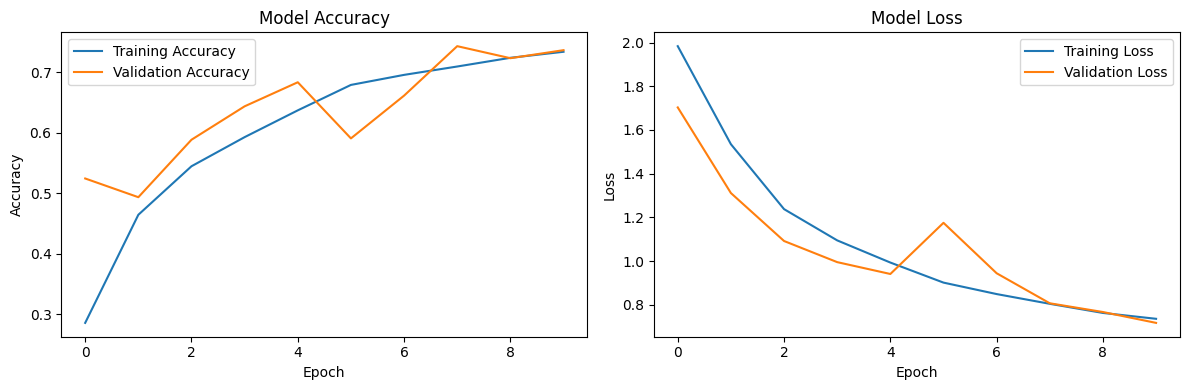

In [34]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
predictions = resnet_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step


Number of examples:  565


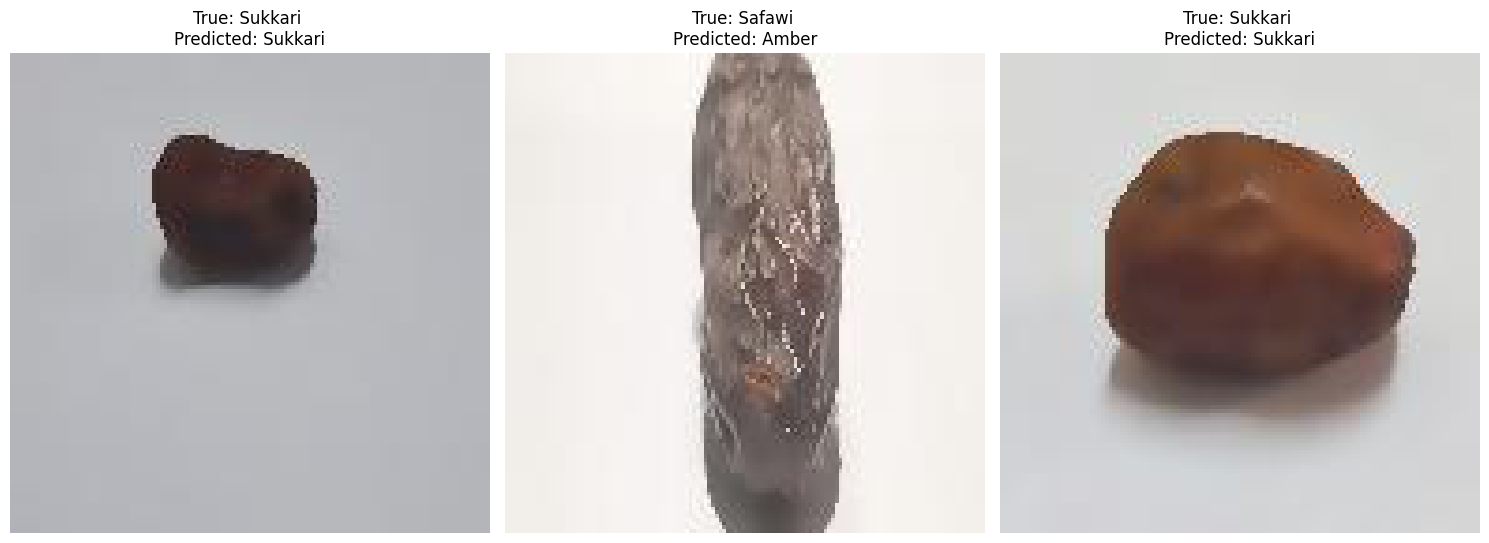

In [36]:
date_type_list = list(date_types.values())
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
print("Number of examples: ", len(X_test))
for i, ax in enumerate(axes.flat):
    i=np.random.randint(0,len(X_test))
    ax.imshow(X_test[i].reshape(input_shape))
    ax.set_title(f"True: {date_type_list[np.argmax(y_test[i])]} \nPredicted: {date_type_list[predicted_classes[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

**ResNet50 may have been too deep or unsuited for the specific visual details in your dataset without proper tuning.**


## MobileNetV2

In [37]:
# Load and prepare the data
X, y, date_types = PrepareData(img_size=(128, 128))
X_train, X_test, X_val, y_train, y_test, y_val = FinalStage(X, y)

num_classes = 9
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

Processed data shape: (16932, 512), (16932,)
Number of classes: 9


In [38]:
# Done to reset the model to not get confused with the previous model
from tensorflow.keras.models import Model 

def MobileNetV2_Model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [39]:
input_shape = (128, 128, 3)
mobilenet_model = MobileNetV2_Model(input_shape, num_classes)

In [40]:
# Compile the model
mobilenet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = mobilenet_model.fit(X_train, y_train,
                           epochs=10,
                           batch_size=32,
                           validation_data=(X_val, y_val),
                           verbose=1)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5491 - loss: 1.3229 - val_accuracy: 0.8274 - val_loss: 0.4219
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8957 - loss: 0.3113 - val_accuracy: 0.8960 - val_loss: 0.2677
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9442 - loss: 0.1796 - val_accuracy: 0.9425 - val_loss: 0.2013
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9702 - loss: 0.1155 - val_accuracy: 0.9093 - val_loss: 0.2454
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9783 - loss: 0.0930 - val_accuracy: 0.9336 - val_loss: 0.1895
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9910 - loss: 0.0572 - val_accuracy: 0.9403 - val_loss: 0.1727
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9966 - loss: 0.0412 - val_accuracy: 0.9358 - val_loss: 0.1921
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9967 - loss: 0.0337 - val_accuracy: 0.9403 - 

In [41]:
# Evaluate the model
test_loss, test_acc = mobilenet_model.evaluate(X_test, y_test, verbose=2)
training_accuracy = history.history['accuracy'][-1]
print(f'Training accuracy: {training_accuracy:.4f}')
print(f'Test accuracy: {test_acc}')

18/18 - 1s - 56ms/step - accuracy: 0.9504 - loss: 0.1606
Training accuracy: 0.9989
Test accuracy: 0.9504424929618835


# DNN

## DNN Model 1

In [42]:
def Model_DNN_1(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

**Way too bad results to even bother keeping**

## DNN Model 2

In [43]:
def Model_DNN_2(input_shape,num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

**Way too bad results to even bother keeping**